In [1]:
import bempp.api
import numpy as np
import scipy 
import krypy
import time
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator
from scipy.sparse.linalg import LinearOperator

In [2]:
h = 0.05
r1 = 1
r2 = 1
dist = 3
sphere1 = bempp.api.shapes.sphere(r = r1, h=h, origin=((dist/2) + r1, 0, 0))
sphere2 = bempp.api.shapes.sphere(r = r2, h=h, origin=(-((dist/2) + r2), 0, 0))

In [3]:
sphere1.number_of_elements

12578

In [4]:
space1 = bempp.api.function_space(sphere1,'P',1)
space2 = bempp.api.function_space(sphere2,'P',1)

In [5]:
dim = 100

In [6]:
wavenumber = 0 * 1j

In [7]:
slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space1, space1, space1, wavenumber, assembler= 'fmm')
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space2, space1, space1, wavenumber, assembler= 'fmm')
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space1, space2, space2, wavenumber, assembler= 'fmm')
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space2, space2, space2, wavenumber, assembler= 'fmm')

slp11_ = bempp.api.operators.boundary.helmholtz.single_layer(space1, space1, space1, wavenumber)
slp22_ = bempp.api.operators.boundary.helmholtz.single_layer(space2, space2, space2, wavenumber)

In [8]:
mat11 = slp11.weak_form()
mat12 = slp12.weak_form()
mat21 = slp21.weak_form()
mat22 = slp22.weak_form()

mat_ = [[mat11,mat12],[mat21,mat22]] 
mat = BlockedDiscreteOperator(np.array(mat_))

mat11_ = slp11_.weak_form().A
mat22_ = slp22_.weak_form().A

L1, U1 = scipy.linalg.lu_factor(mat11_)
L2, U2 = scipy.linalg.lu_factor(mat22_)

In [9]:
def mv(v):
    return mat @ (list(scipy.linalg.lu_solve([L1, U1], v[0:mat11_.shape[0]])) + list(scipy.linalg.lu_solve([L2, U2], v[mat11_.shape[0]:])))

n = mat11_.shape[0] + mat22_.shape[0]
x = (np.ones(n)/np.linalg.norm(np.ones(n), 2)).reshape((n,1))
L_Op = LinearOperator(shape = (n, n) , matvec=mv)

In [10]:
V, H = krypy.utils.arnoldi(L_Op, x, maxiter = dim,  ortho='dmgs')
evals_H, evect_H = np.linalg.eig(H[0:dim, :]) 

In [11]:
logdet = 0
for eval_ in evals_H:
    logdet += np.log(eval_)
print(logdet)

-0.04495802148848054


In [13]:
%store -r evals_H_

In [14]:
rel_dist = []
for i in range(100):
    rel_dist.append(abs(sorted(list(evals_H_))[i] - sorted(evals_H)[i])/sorted(list(evals_H_))[i])

(array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

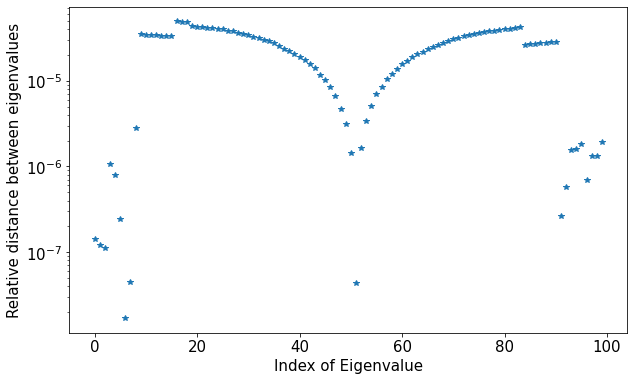

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = [10,6])
plt.semilogy(range(dim), rel_dist, '*')
plt.ylabel('Relative distance between eigenvalues', fontsize = 15)
plt.xlabel('Index of Eigenvalue', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [19]:
np.sum(np.log(sorted(evals_H)[10:90]))

-0.00020807933084288617